In [1]:
# 1. Import Python libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import glob as glob

In [2]:
# 2. Import the dataset

acl_train = pd.read_csv("dataset/train-acl.csv")
acl_valid = pd.read_csv("dataset/valid-acl.csv")
acl_data = pd.concat([acl_train, acl_valid], ignore_index = True)

meniscus_train = pd.read_csv("dataset/train-meniscus.csv")
meniscus_valid = pd.read_csv("dataset/valid-meniscus.csv")
meniscus_data = pd.concat([meniscus_train, meniscus_valid], ignore_index = True)

abnormal_train = pd.read_csv("dataset/train-abnormal.csv")
abnormal_valid = pd.read_csv("dataset/valid-abnormal.csv")
abnormal_data = pd.concat([abnormal_train, abnormal_valid], ignore_index = True)

In [3]:
acl_data

,case_study,result
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
1245,1245,1
1246,1246,1
1247,1247,0
1248,1248,1


In [4]:
meniscus_data

,case_study,result
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0
...,...,...
1245,1245,1
1246,1246,1
1247,1247,1
1248,1248,1


In [5]:
abnormal_data

,case_study,result
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
1245,1245,1
1246,1246,1
1247,1247,1
1248,1248,1


In [6]:
train_dir = 'dataset/train'
valid_dir = 'dataset/valid'

planes = ['axial', 'coronal', 'sagittal']
datasets = {'train': train_dir, 'valid': valid_dir}

for dataset, path in datasets.items():
    print(f'\nNumber of exams in {dataset} set:')
    for plane in planes:
        print(plane, len(glob.glob(f'{path}/{plane}/*.npy')))


Number of exams in train set:
axial 1130
coronal 1130
sagittal 1130

Number of exams in valid set:
axial 120
coronal 120
sagittal 120


In [7]:
# View the first 5 exams for each plane in the training set

for plane in planes:
    print(f"\nFirst 5 {plane} exams in the training set:")
    train_exams = glob.glob(f'{train_dir}/{plane}/*.npy')[:5]
    for exam in train_exams:
        series = np.load(exam)
        print(f"{exam}: {series.shape}")


First 5 axial exams in the training set:
dataset/train/axial\0000.npy: (44, 256, 256)
dataset/train/axial\0001.npy: (30, 256, 256)
dataset/train/axial\0002.npy: (38, 256, 256)
dataset/train/axial\0003.npy: (33, 256, 256)
dataset/train/axial\0004.npy: (40, 256, 256)

First 5 coronal exams in the training set:
dataset/train/coronal\0000.npy: (36, 256, 256)
dataset/train/coronal\0001.npy: (20, 256, 256)
dataset/train/coronal\0002.npy: (32, 256, 256)
dataset/train/coronal\0003.npy: (28, 256, 256)
dataset/train/coronal\0004.npy: (34, 256, 256)

First 5 sagittal exams in the training set:
dataset/train/sagittal\0000.npy: (36, 256, 256)
dataset/train/sagittal\0001.npy: (26, 256, 256)
dataset/train/sagittal\0002.npy: (32, 256, 256)
dataset/train/sagittal\0003.npy: (30, 256, 256)
dataset/train/sagittal\0004.npy: (32, 256, 256)


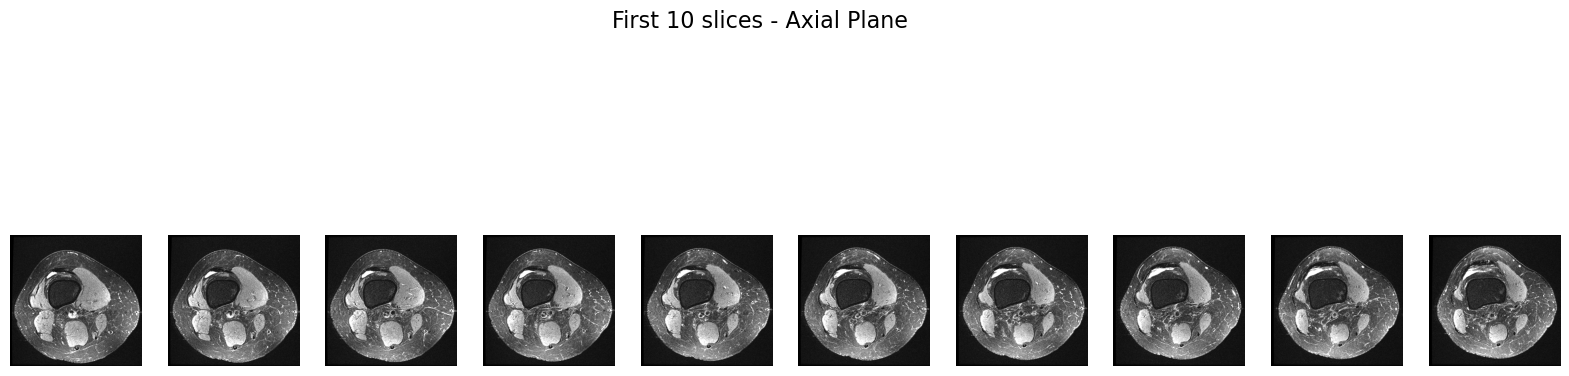

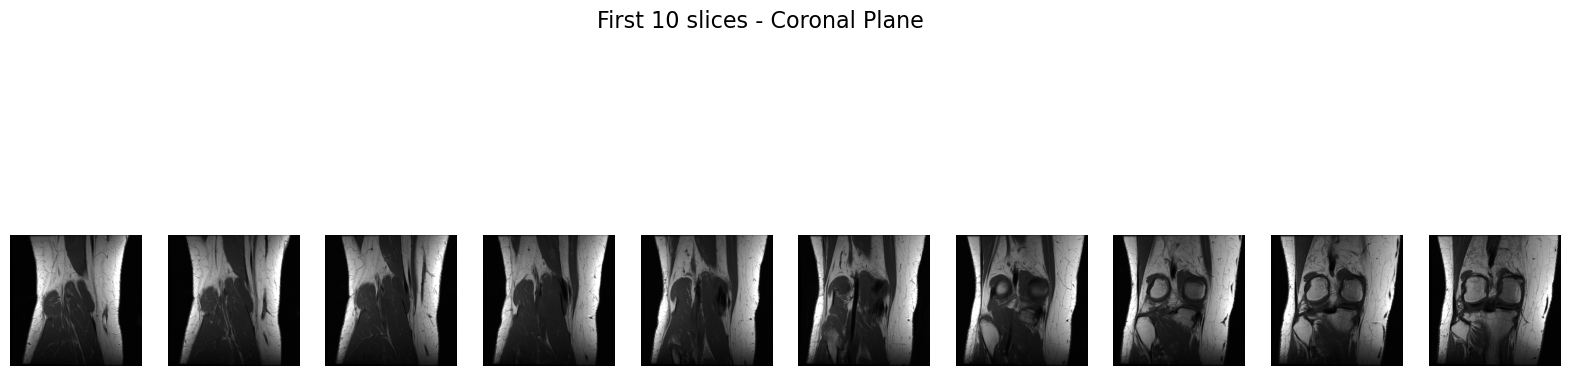

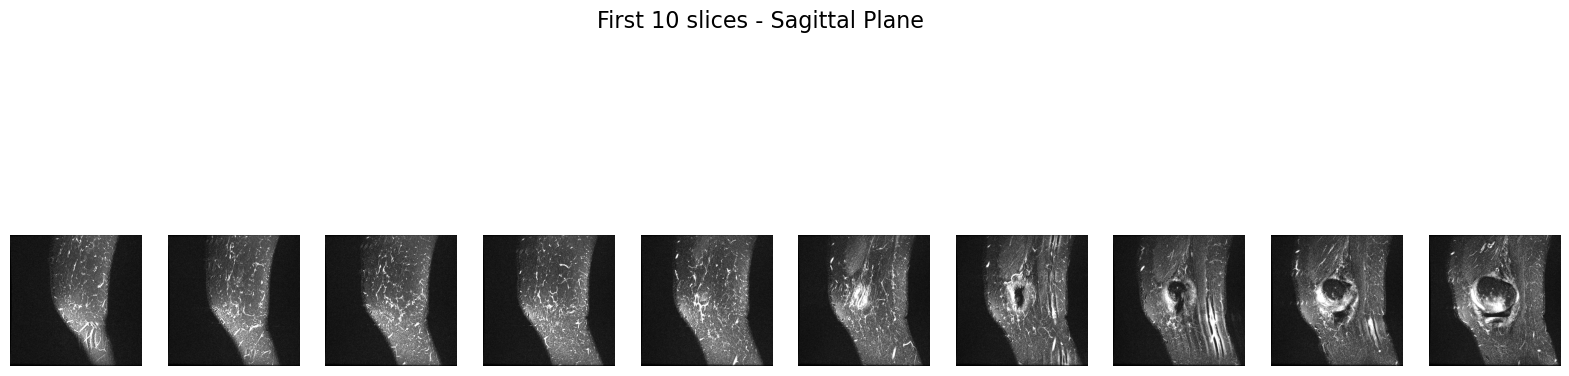

In [8]:
def plot_first_ten(path, plane):
    series = np.load(path)[:10]

    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(f'First 10 slices - {plane.capitalize()} Plane', fontsize=16)
    
    for i, image in enumerate(series):
        ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
        plt.imshow(image, cmap='gray')
        plt.axis('off')

# Example usage for all planes
for plane in planes:
    train_exams = glob.glob(f'{train_dir}/{plane}/*.npy')
    plot_first_ten(train_exams[0], plane)

## Functions

Taken from GitHub

In [13]:
import os
from glob import glob
from PIL import Image

import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms

import os
import csv

import numpy as np
import torch
from sklearn import metrics

class MRNetDataset(Dataset):
    def __init__(self, dataset_dir, labels_path, plane, transform=None, device=None):
        self.case_paths = sorted(glob(f'{dataset_dir}/{plane}/**.npy'))
        self.labels_df = pd.read_csv(labels_path)
        self.transform = transform
        self.window = 7
        self.device = device
        if self.device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def __len__(self):
        return len(self.case_paths)

    def __getitem__(self, idx):
        case_path = self.case_paths[idx]
        series = preprocess_data(case_path, self.transform)

        case_id = int(os.path.splitext(os.path.basename(case_path))[0])
        case_row = self.labels_df[self.labels_df.case == case_id]
        diagnoses = case_row.values[0,1:].astype(np.float32)
        labels = torch.tensor(diagnoses)

        return (series, labels)


def make_dataset(data_dir, dataset_type, plane, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    dataset_dir = f'{data_dir}/{dataset_type}'
    # Updated the labels_path to point to the correct file
    labels_path = f'{data_dir}/{dataset_type}-{plane}.csv'

    if dataset_type == 'train':
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(25, translate=(0.1, 0.1)),
            transforms.ToTensor()
        ])
    elif dataset_type == 'valid':
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])
    else:
        raise ValueError('Dataset needs to be train or valid.')

    dataset = MRNetDataset(dataset_dir, labels_path, plane, transform=transform, device=device)

    return dataset

def preprocess_data(case_path, transform=None):
    series =np.load(case_path).astype(np.float32)
    series = torch.tensor(np.stack((series,)*3, axis=1))

    if transform is not None:
        for i, slice in enumerate(series.split(1)):
            series[i] = transform(slice.squeeze())

    series = (series - series.min()) / (series.max() - series.min()) * MAX_PIXEL_VAL
    series = (series - MEAN) / STD

    return series


def create_output_dir(exp, plane):
    out_dir = f'./models/{exp}'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    losses_path = create_losses_csv(out_dir, plane)

    return out_dir, losses_path


def create_losses_csv(out_dir, plane):
    losses_path = f'{out_dir}/losses_{plane}.csv'

    with open(f'{losses_path}', mode='w') as losses_csv:
        fields = ['t_abnormal', 't_acl', 't_meniscus',
                    'v_abnormal', 'v_acl', 'v_meniscus']
        writer = csv.DictWriter(losses_csv, fieldnames=fields)
        writer.writeheader()

    return losses_path


def calculate_aucs(all_labels, all_preds):
    all_labels = np.array(all_labels).transpose()
    all_preds =  np.array(all_preds).transpose()

    aucs = [metrics.roc_auc_score(labels, preds) for \
            labels, preds in zip(all_labels, all_preds)]

    return aucs


def print_stats(batch_train_losses, batch_valid_losses,
                valid_labels, valid_preds):
    aucs = calculate_aucs(valid_labels, valid_preds)

    print(f'Train losses - abnormal: {batch_train_losses[0]:.3f},',
          f'acl: {batch_train_losses[1]:.3f},',
          f'meniscus: {batch_train_losses[2]:.3f}',
          f'\nValid losses - abnormal: {batch_valid_losses[0]:.3f},',
          f'acl: {batch_valid_losses[1]:.3f},',
          f'meniscus: {batch_valid_losses[2]:.3f}',
          f'\nValid AUCs - abnormal: {aucs[0]:.3f},',
          f'acl: {aucs[1]:.3f},',
          f'meniscus: {aucs[2]:.3f}')


def save_losses(train_losses , valid_losses, losses_path):
    with open(f'{losses_path}', mode='a') as losses_csv:
        writer = csv.writer(losses_csv)
        writer.writerow(np.append(train_losses, valid_losses))


def save_checkpoint(epoch, plane, diagnosis, model, optimizer, out_dir):
    print(f'Min valid loss for {diagnosis}, saving the checkpoint...')

    checkpoint = {
        'epoch': epoch,
        'plane': plane,
        'diagnosis': diagnosis,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    chkpt = f'cnn_{plane}_{diagnosis}_{epoch:02d}.pt'
    torch.save(checkpoint, f'{out_dir}/{chkpt}')

In [11]:
import torch
from torch.utils.data import DataLoader

def make_data_loader(data_dir, dataset_type, plane, device=None, shuffle=False):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    dataset = make_dataset(data_dir, dataset_type, plane, device=device)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=shuffle)

    return data_loader

In [ ]:
import torch
import torch.nn as nn
from torchvision import models


class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.alexnet = models.alexnet(pretrained=True).features
        self.fc = nn.Linear(256, 1)

        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=None, padding=0)
        self.dropout = nn.Dropout(p=0.5)

    @property
    def features(self):
        return self.alexnet

    @property
    def classifier(self):
        return self.fc

    def forward(self, batch):
        batch_out = torch.tensor([]).to(batch.device)

        for series in batch:
            out = torch.tensor([]).to(batch.device)
            for image in series:
                out = torch.cat((out, self.features(image.unsqueeze(0))), 0)

            out = self.avg_pool(out).squeeze()
            out = out.max(dim=0, keepdim=True)[0].squeeze()

            out = self.classifier(self.dropout(out))

            batch_out = torch.cat((batch_out, out), 0)

        return batch_out

import sys
import numpy as np
import pandas as pd
from docopt import docopt
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim

from data_loader import make_data_loader
from utils import create_output_dir, \
                  print_stats,       \
                  save_losses,       \
                  save_checkpoint


def calculate_weights(data_dir, dataset_type, device):
    diagnoses = ['abnormal', 'acl', 'meniscus']

    labels_path = f'{data_dir}/{dataset_type}_labels.csv'
    labels_df = pd.read_csv(labels_path)

    weights = []

    for diagnosis in diagnoses:
        neg_count, pos_count = labels_df[diagnosis].value_counts().sort_index()
        weight = torch.tensor([neg_count / pos_count])
        weight = weight.to(device)
        weights.append(weight)

    return weights


def make_adam_optimizer(model, lr, weight_decay):
    return optim.Adam(model.parameters(), lr, weight_decay=weight_decay)


def make_lr_scheduler(optimizer,
                      mode='min',
                      factor=0.3,
                      patience=1,
                      verbose=False):
    return optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                mode=mode,
                                                factor=factor,
                                                patience=patience,
                                                verbose=verbose)


def batch_forward_backprop(models, inputs, labels, criterions, optimizers):
    losses = []

    for i, (model, label, criterion, optimizer) in \
            enumerate(zip(models, labels[0], criterions, optimizers)):
        model.train()
        optimizer.zero_grad()

        out = model(inputs)
        loss = criterion(out, label.unsqueeze(0))
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.array(losses)


def batch_forward(models, inputs, labels, criterions):
    preds = []
    losses = []

    for i, (model, label, criterion) in \
            enumerate(zip(models, labels[0], criterions)):
        model.eval()

        out = model(inputs)
        preds.append(out.item())
        loss = criterion(out, label.unsqueeze(0))
        losses.append(loss.item())

    return np.array(preds), np.array(losses)


def update_lr_schedulers(lr_schedulers, batch_valid_losses):
    for scheduler, v_loss in zip(lr_schedulers, batch_valid_losses):
        scheduler.step(v_loss)


def main(data_dir, plane, epochs, lr, weight_decay, device=None):
    diagnoses = ['abnormal', 'acl', 'meniscus']

    exp = f'{datetime.now():%Y-%m-%d_%H-%M}'
    out_dir, losses_path = create_output_dir(exp, plane)

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    print('Creating data loaders...')

    train_loader = make_data_loader(data_dir, 'train', plane, device, shuffle=True)
    valid_loader = make_data_loader(data_dir, 'valid', plane, device)

    print(f'Creating models...')

    # Create a model for each diagnosis

    models = [MRNet().to(device), MRNet().to(device), MRNet().to(device)]

    # Calculate loss weights based on the prevalences in train set

    pos_weights = calculate_weights(data_dir, 'train', device)
    criterions = [nn.BCEWithLogitsLoss(pos_weight=weight) \
                  for weight in pos_weights]

    optimizers = [make_adam_optimizer(model, lr, weight_decay) \
                  for model in models]

    lr_schedulers = [make_lr_scheduler(optimizer) for optimizer in optimizers]

    min_valid_losses = [np.inf, np.inf, np.inf]

    print(f'Training a model using {plane} series...')
    print(f'Checkpoints and losses will be save to {out_dir}')

    for epoch, _ in enumerate(range(epochs), 1):
        print(f'=== Epoch {epoch}/{epochs} ===')

        batch_train_losses = np.array([0.0, 0.0, 0.0])
        batch_valid_losses = np.array([0.0, 0.0, 0.0])

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            batch_loss = batch_forward_backprop(models, inputs, labels,
                                                criterions, optimizers)
            batch_train_losses += batch_loss

        valid_preds = []
        valid_labels = []

        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            batch_preds, batch_loss = \
                batch_forward(models, inputs, labels, criterions)
            batch_valid_losses += batch_loss

            valid_labels.append(labels.detach().cpu().numpy().squeeze())
            valid_preds.append(batch_preds)

        batch_train_losses /= len(train_loader)
        batch_valid_losses /= len(valid_loader)

        print_stats(batch_train_losses, batch_valid_losses,
                    valid_labels, valid_preds)
        save_losses(batch_train_losses, batch_valid_losses, losses_path)

        update_lr_schedulers(lr_schedulers, batch_valid_losses)

        for i, (batch_v_loss, min_v_loss) in \
                enumerate(zip(batch_valid_losses, min_valid_losses)):

            if batch_v_loss < min_v_loss:
                save_checkpoint(epoch, plane, diagnoses[i], models[i],
                                optimizers[i], out_dir)

                min_valid_losses[i] = batch_v_loss


if __name__ == '__main__':
    arguments = docopt(__doc__)

    print('Parsing arguments...')

    main(arguments['<data_dir>'],
         arguments['<plane>'],
         int(arguments['<epochs>']),
         float(arguments['--lr']),
         float(arguments['--weight-decay']),
         arguments['--device'])

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train/train-axial.csv'

In [ ]:
# Function to test the model
def test_model(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images).squeeze()
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.numpy())

    return predictions, true_labels

# Example usage for all planes
for plane in planes:
    print(f"Testing model on {plane} plane:")
    test_dataset = make_dataset('dataset/valid', 'valid', plane, transform=plane_transforms[plane])
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    predictions, true_labels = test_model(model, test_loader, device)
    print(f"Predictions for {plane} plane:", predictions)
    print(f"True Labels for {plane} plane:", true_labels)